# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [32]:
def entropy2(k1, k2):
    p1 = k1 / (k1 + k2)
    p2 = k2 / (k1 + k2)
    if p1 != 0 and p2 != 0:
        h = -(p1 * np.log(p1) + p2 * np.log(p2))
    elif p1 == 0:
        h = -(p2 * np.log(p2))
    else:
        h = -(p1 * np.log(p1))
    return round(h, 2)


print('Энтропия:', entropy2(8, 2))

Энтропия: 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [33]:
def crit_info(h, Rl, Rr):
    Rm = (Rl[0] + Rr[0], Rl[1] + Rr[1])
    Q = h(Rm[0], Rm[1]) - sum(Rl) / sum(Rm) * h(Rl[0], Rl[1]) - sum(Rr) / sum(Rm) * h(Rr[0], Rr[1])
    return Q
    

print('Критерий информативности (энтропия):', crit_info(entropy2, (8, 0), (0, 2)))

Критерий информативности (энтропия): 0.5


In [42]:
def gini2(k1, k2):
    p1 = k1 / (k1 + k2)
    p2 = k2 / (k1 + k2)
    h = p1 * (1 - p1) + p2 * (1 - p2)
    return round(h, 2)


print('Индекс Джини:', gini2(8, 2))
print('Критерий информативности (Джини):', crit_info(gini2, (8, 0), (0, 2)))

Индекс Джини: 0.32
Критерий информативности (Джини): 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [37]:
def reg_leaf(values):
    return round(np.mean(values), 2)


values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
print('Усреднение в листе:', reg_leaf(values))

Усреднение в листе: 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [44]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [428]:
def q_std(x):
    std_all = np.std(x)
    n = x.shape[0]
    
    a = np.add.accumulate(x[:-1]) # сумма слева
    b = np.arange(1, len(x), 1) # кол-во слева
    mean_left = a / b # среднее слева
    deviation = np.subtract.outer(x[:-1], mean_left).T # x - x_mean
    deviation_sq = np.square(deviation) # (x - x_mean) ** 2
    deviation_sq_acc = np.add.accumulate(deviation_sq, 1) # sums of (x - x_mean) ** 2
    std_upper = np.diagonal(deviation_sq_acc) # correct vector of sums of (x - x_mean) ** 2
    std_left = std_upper / b
    
    c = np.add.accumulate(x[::-1])[::-1][1::] # сумма справа
    d = np.arange(len(x) - 1, 0, -1) # кол-во справа
    mean_right = c / d # среднее справа
    deviation = np.subtract.outer(x[1:], mean_right).T # x - x_mean
    deviation_sq = np.square(deviation) # (x - x_mean) ** 2
    deviation_sq_acc = np.add.accumulate(np.fliplr(deviation_sq), 1) # sums of (x - x_mean) ** 2
    std_upper = np.fliplr(deviation_sq_acc).diagonal() # correct vector of sums of (x - x_mean) ** 2
    std_right = std_upper / d
    
    q = std_all - a / n * std_left - c / n * std_right
    return q


def q_gini(x): # use with vectorize
    n = x.shape[0]
    b = np.arange(1, len(x), 1) # кол-во слева
    # подсчитать кол-во объектов для каждой категории с каждой стороны
    # поделить эти числа на n
    # и т.д.


def threshold_maker(x):
    thresholds = (x[1:] + x[:-1]) / 2
    return(thresholds)


def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
    
    permutation = feature_vector.argsort()
    features_sorted = feature_vector[permutation]
    targets_sorted = target_vector[permutation]
    
    if task == 'regression':
        thresholds = threshold_maker(features_sorted)
        variances = q_std(targets_sorted)
        variance_best = variances.max()
        threshold_best = thresholds[list(variances).index(variance_best)]
        return thresholds, variances, threshold_best, variance_best
    
    elif task == 'classification':
        thresholds = threshold_maker(features_sorted)
        v_q_gini = np.vectorize(q_gini) # не дописал...
        # ginis = v_q_gini(...)
    
    

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

#print(thresholds, variances, threshold_best, variance_best)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [424]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

#print(boston["DESCR"])

c:\users\egorb\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [425]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

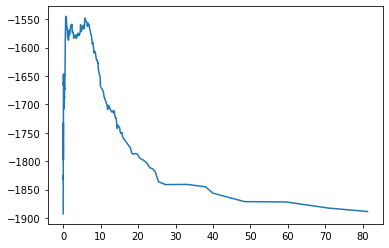

In [426]:
# это график отрицательного критерия ошибки!
permutation = X["CRIM"].to_numpy().argsort()
features_sorted = X["CRIM"].to_numpy()[permutation]
thresholds = threshold_maker(features_sorted)
plt.plot(thresholds, q_std(y[permutation]))
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [384]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

In [348]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

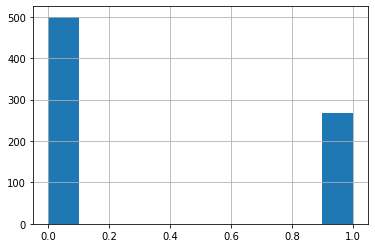

In [349]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [350]:
train, test = train_test_split(data, test_size=0.3, random_state=42)
tr_tr, tr_valid = train_test_split(train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [363]:
X = tr_tr.iloc[:, :-1]
y = tr_tr.iloc[:, -1]
X_val = tr_valid.iloc[:, :-1]
y_val = tr_valid.iloc[:, -1]

In [376]:
f1_best = -1
max_depth_list = np.arange(1,20,1)
min_samples_leaf_list = np.arange(1,30,1)
for i in max_depth_list:
    for j in min_samples_leaf_list:
        tree = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j)
        clf = tree.fit(X, y)
        y_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        if f1 > f1_best:
            f1_best = f1
            max_depth_best = i
            min_samples_best = j
max_depth_best, min_samples_best

(7, 7)

In [377]:
X_tr = train.iloc[:, :-1]
y_tr = train.iloc[:, -1]
X_te = test.iloc[:, :-1]
y_te = test.iloc[:, -1]

In [381]:
tree = DecisionTreeClassifier(max_depth=max_depth_best, min_samples_leaf=min_samples_best)
clf = tree.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
accuracy = accuracy_score(y_te, y_pred)
precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
auc_roc = roc_auc_score(y_te, y_pred)
print('Accuracy:', round(accuracy,2), 'Precision:', round(precision,2), 'Recall:', round(recall, 2), 'Auc_roc:', round(auc_roc,2))

Accuracy: 0.7 Precision: 0.56 Recall: 0.62 Auc_roc: 0.68


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [382]:
bag = BaggingClassifier(n_estimators=50)
clf = bag.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
accuracy = accuracy_score(y_te, y_pred)
precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
auc_roc = roc_auc_score(y_te, y_pred)
print('Accuracy:', round(accuracy,2), 'Precision:', round(precision,2), 'Recall:', round(recall, 2), 'Auc_roc:', round(auc_roc,2))

Accuracy: 0.71 Precision: 0.58 Recall: 0.62 Auc_roc: 0.69


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [403]:
f1_best = -1
max_depth_list = np.arange(1,30,1)
min_samples_split = np.arange(2,20,1)
for i in max_depth_list:
    for j in min_samples_split:
        tree = RandomForestClassifier(max_depth=i, min_samples_split=j, n_estimators=50)
        cv_results = cross_validate(tree, X, y, cv=4, scoring='f1')
        f1_mean = np.mean(cv_results['test_score'])
        if f1_mean > f1_best:
            f1_best = f1_mean
            max_depth_best = i
            min_samples_split_best = j
max_depth_best, min_samples_split_best

(11, 2)

In [404]:
rand_forest = RandomForestClassifier(max_depth=max_depth_best, min_samples_split=min_samples_split_best, n_estimators=50)
clf = rand_forest.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
accuracy = accuracy_score(y_te, y_pred)
precision = precision_score(y_te, y_pred)
recall = recall_score(y_te, y_pred)
auc_roc = roc_auc_score(y_te, y_pred)
print('Accuracy:', round(accuracy,2), 'Precision:', round(precision,2), 'Recall:', round(recall, 2), 'Auc_roc:', round(auc_roc,2))

Accuracy: 0.76 Precision: 0.66 Recall: 0.62 Auc_roc: 0.73


### Случайный лес оказался лучше  по всем метрикам качества! Ура!

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [412]:
auc_rocs = []
for n in range(1, 151):
    rand_forest = RandomForestClassifier(max_depth=max_depth_best, min_samples_split=min_samples_split_best, n_estimators=n)
    clf = rand_forest.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    auc_roc = roc_auc_score(y_te, y_pred)
    auc_rocs.append(auc_roc)

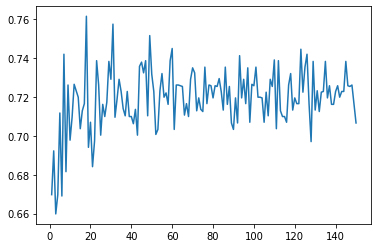

In [413]:
plt.plot(np.arange(1,151,1), auc_rocs)
plt.show()

Ответ: примерно после n=15 график хаотично и резко меняет своё направление вокруг значения auc_roc около 0.72. При этом есть подозрение, что волатильность постепенно снижается, но точность от существенного увеличения n не растёт. Зато метрика качества случайно меняется от добавления нового дерева в лес.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<BarContainer object of 8 artists>

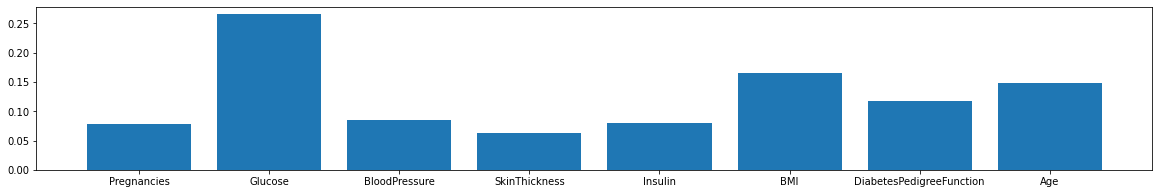

In [422]:
rand_forest = RandomForestClassifier(max_depth=max_depth_best, min_samples_split=min_samples_split_best, n_estimators=50)
clf = rand_forest.fit(X_tr, y_tr)
importnaces = clf.feature_importances_
fig, ax = plt.subplots(figsize=(20,3))
ax.bar(X_tr.columns, height=importnaces)

Важнее всех оказался признак Glucose